# Compositional analysis of the COPD-IAV scRNA dataset using milo using MILO 
and the single cell best practices tutorial https://www.sc-best-practices.org/conditions/compositional.html#without-labeled-clusters:
- Developed by: Christian Eger
- Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg
- Created on: 231207
- Last modified: 240105<br>
6 Patients with and 6 without chronic obstructive pulmonary disease (COPD).
Epithelial cells extracted with a lung wash and exposed to IAV (Control and IAV n=3 for both COPD and healthy patients)
--> scRNA-seq and cell types annotated

## Troubleshooting

In case of error during installation of 'edgeR' into the R environment (on apple silicon): "C17 standard requested but CC17 is not defined<br>
R CMD config CC17 <br>
#if it returns nothing create a config file Makevars in /Users/username/.R/Makevars<br>
mkdir /Users/username/.R<br>
cd /Users/username/.R<br>
touch Makevars<br>
vim Makevars <br>
#insert: CC17 = clang -arch arm64 -std=gnu17<br>

## Import statements and environment prep

In [1]:
import scanpy as sc
import pertpy as pt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
import scvi
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
rpy2.robjects.numpy2ri.activate()


## Data preparation

### Data loading

In [3]:
adata = sc.read_h5ad("Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'


In [4]:


adata_cell_compartment = adata[adata.obs['cell_compartment'].isin(['Ciliated'])]
adata_cell_compartment


View of AnnData object with n_obs × n_vars = 3519 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [5]:
adata_cell_compartment.obs

,sex,age,ethnicity,PaCO2,donor,infection,disease,SMK,illumina_stimunr,bd_rhapsody,...,group,Viral_score,cell_type,cell_states,leiden,cell_compartment,seed_labels,_scvi_batch,_scvi_labels,C_scANVI
493638-ST07_CSE_CTRL-V1,male,67,caucasian,88.8,GNR-06,CTRL,healthy,7,21_0017,1,...,healthy_ctrl,-0.993291,ciliated,OMG+Ciliated,MultiC_0,Ciliated,Ciliated,0,1,Ciliated
816750-ST07_CSE_CTRL-V1,male,67,caucasian,88.8,GNR-06,CTRL,healthy,7,21_0017,1,...,healthy_ctrl,-1.685051,ciliated,APOD+Ciliated,MultiC_1,Ciliated,Ciliated,0,1,Ciliated
767740-ST07_CSE_CTRL-V1,male,67,caucasian,88.8,GNR-06,CTRL,healthy,7,21_0017,1,...,healthy_ctrl,-1.972678,ciliated,APOD+Ciliated,MultiC_1,Ciliated,Ciliated,0,1,Ciliated
183623-ST07_CSE_CTRL-V1,male,67,caucasian,88.8,GNR-06,CTRL,healthy,7,21_0017,1,...,healthy_ctrl,-1.287201,ciliated,APOD+Ciliated,MultiC_1,Ciliated,Ciliated,0,1,Ciliated
585589-ST07_CSE_CTRL-V1,male,67,caucasian,88.8,GNR-06,CTRL,healthy,7,21_0017,1,...,healthy_ctrl,-1.488834,ciliated,p53_Ciliated,MultiC_2,Ciliated,Ciliated,0,1,Ciliated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12549563-CSE03_IAV-V6,male,66,caucasian,76.8,CSE-03,IAV,COPD,8,21_0507,6,...,copd_iav,-0.647322,ciliated,OMG+Ciliated,MultiC_0,Ciliated,Ciliated,0,1,Ciliated
5906311-CSE03_IAV-V6,male,66,caucasian,76.8,CSE-03,IAV,COPD,8,21_0507,6,...,copd_iav,-1.245491,ciliated,OMG+Ciliated,MultiC_0,Ciliated,Ciliated,0,1,Ciliated
4448713-CSE03_IAV-V6,male,66,caucasian,76.8,CSE-03,IAV,COPD,8,21_0507,6,...,copd_iav,-1.150441,ciliated,OMG+Ciliated,MultiC_0,Ciliated,Ciliated,0,1,Ciliated
11092261-CSE03_IAV-V6,male,66,caucasian,76.8,CSE-03,IAV,COPD,8,21_0507,6,...,copd_iav,2.282087,ciliated,OMG+Ciliated,MultiC_0,Ciliated,Ciliated,0,1,Ciliated


In [6]:
milo = pt.tl.Milo()
mdata = milo.load(adata_cell_compartment)
mdata

MuData object with n_obs × n_vars = 3519 × 27208
  2 modalities
    rna:	3519 x 27208
      obs:	'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
      var:	'mt', 'ribo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
    milo:	0 x 0

### UMAP plotting among conditions

In [7]:
# use logcounts to calculate PCA and neighbors
adata_cell_compartment.layers["counts"] = adata_cell_compartment.X.copy()
adata_cell_compartment.layers["logcounts"] = sc.pp.log1p(adata_cell_compartment.layers["counts"]).copy()
adata_cell_compartment.X = adata_cell_compartment.layers["logcounts"].copy()

sc.pp.highly_variable_genes(
    adata_cell_compartment, n_top_genes=3000, subset=False
)  # 3k genes as used by authors for clustering

sc.pp.pca(adata_cell_compartment)
sc.pp.neighbors(adata_cell_compartment, n_neighbors=10, n_pcs=30, use_rep="X_scANVI")
sc.tl.umap(adata_cell_compartment)

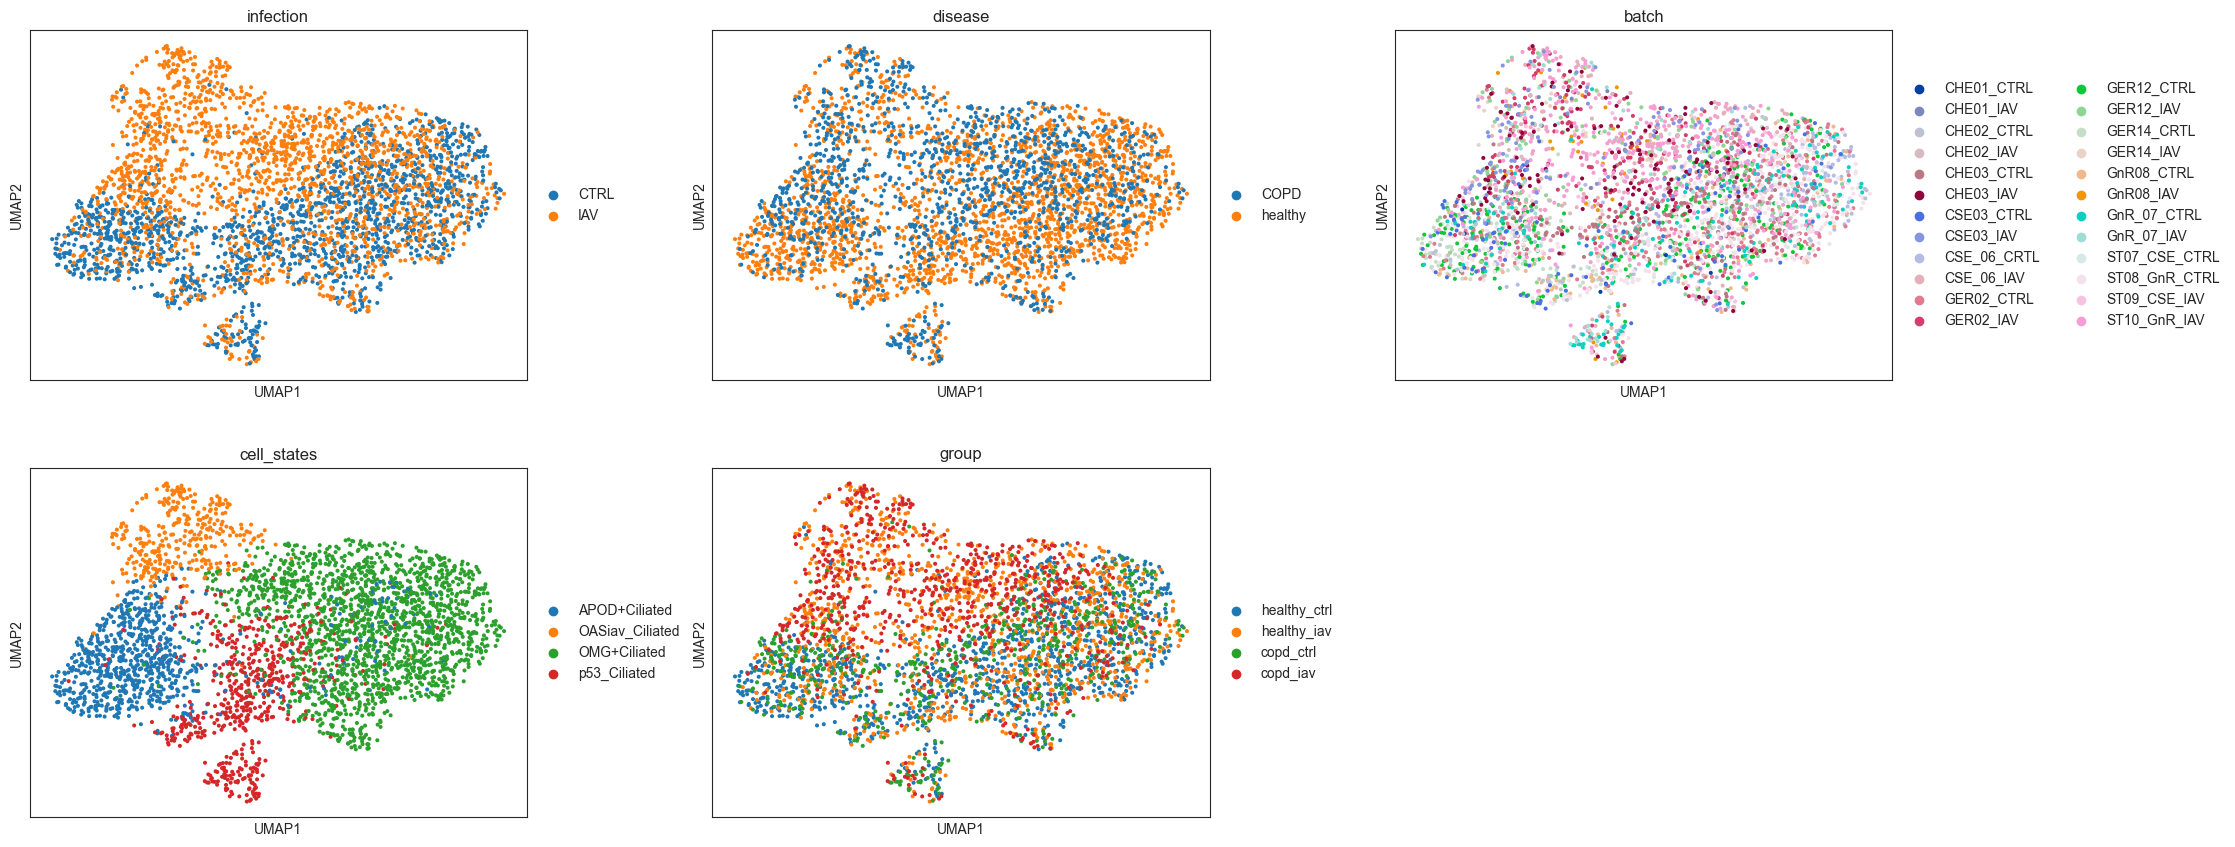

In [8]:
sc.pl.umap(adata_cell_compartment, color=["infection", "disease", "batch", "cell_states", "group"], ncols=3, wspace=0.25)

### Batch correction

In the single cell best practices tutorial there should be a batch correction step next. Skipped because batch correction already took place.

In [9]:
milo.make_nhoods(mdata, prop=0.1)

## Defining of Neighbourhoods

In [10]:
adata_cell_compartment.obsm["nhoods"]

<3519x289 sparse matrix of type '<class 'numpy.float32'>'
	with 5170 stored elements in Compressed Sparse Row format>

Text(0, 0.5, '# neighbouthoods')

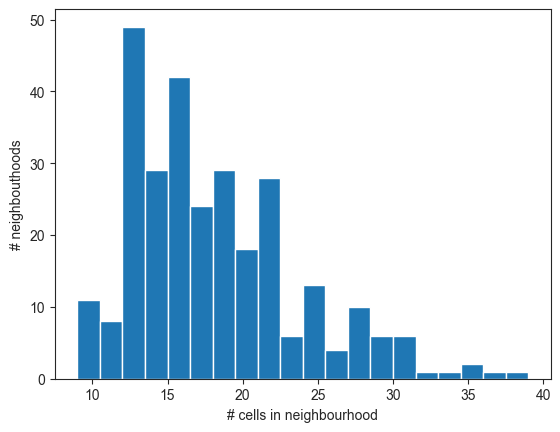

In [11]:
nhood_size = adata_cell_compartment.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [12]:
np.median(nhood_size)

17.0

In [13]:
sc.pp.neighbors(adata_cell_compartment, n_neighbors=50, use_rep="X_scANVI", key_added="milo")
milo.make_nhoods(mdata, neighbors_key="milo", prop=0.1)

Text(0, 0.5, '# neighbouthoods')

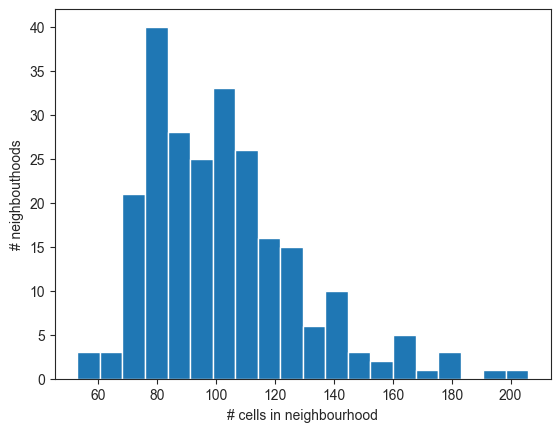

In [14]:
nhood_size = adata_cell_compartment.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [15]:
np.median(nhood_size)

99.0

In [16]:
milo.count_nhoods(mdata, sample_col="batch")

MuData object with n_obs × n_vars = 3519 × 27208
  2 modalities
    rna:	3519 x 27208
      obs:	'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'mt', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'pca', 'neighbors', 'umap', 'infection_colors', 'disease_colors', 'batch_colors', 'cell_states_colors', 'group_colors', 'nhood_neighbors_key', 'milo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', 'X_pca', 'nhoods'
      varm:	'PCs'
      layers:	'counts', 'logcounts'
      obsp:	'distances', 'connectivities', 'milo_distances', 'milo_connectivities'
    milo:	24 x 242
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

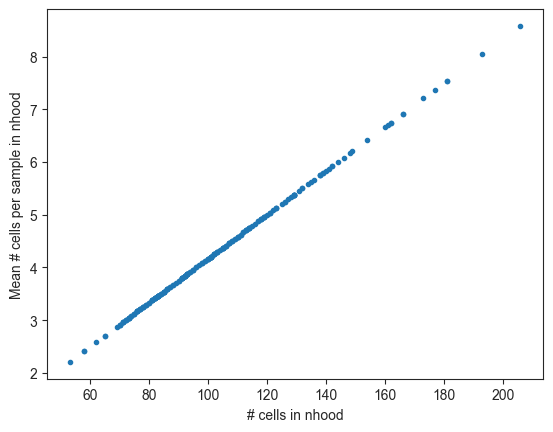

In [17]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

In [18]:
milo.da_nhoods(
    mdata, design="~infection", model_contrasts="infectionIAV-infectionCTRL"
)
milo_results_healthy_iav = mdata["milo"].obs.copy()
milo_results_healthy_iav

,infection,batch
CHE01_CTRL,CTRL,CHE01_CTRL
CHE01_IAV,IAV,CHE01_IAV
CHE02_CTRL,CTRL,CHE02_CTRL
CHE02_IAV,IAV,CHE02_IAV
CHE03_CTRL,CTRL,CHE03_CTRL
CHE03_IAV,IAV,CHE03_IAV
CSE03_CTRL,CTRL,CSE03_CTRL
CSE03_IAV,IAV,CSE03_IAV
CSE_06_CRTL,CTRL,CSE_06_CRTL
CSE_06_IAV,IAV,CSE_06_IAV


## Data Diagnostics

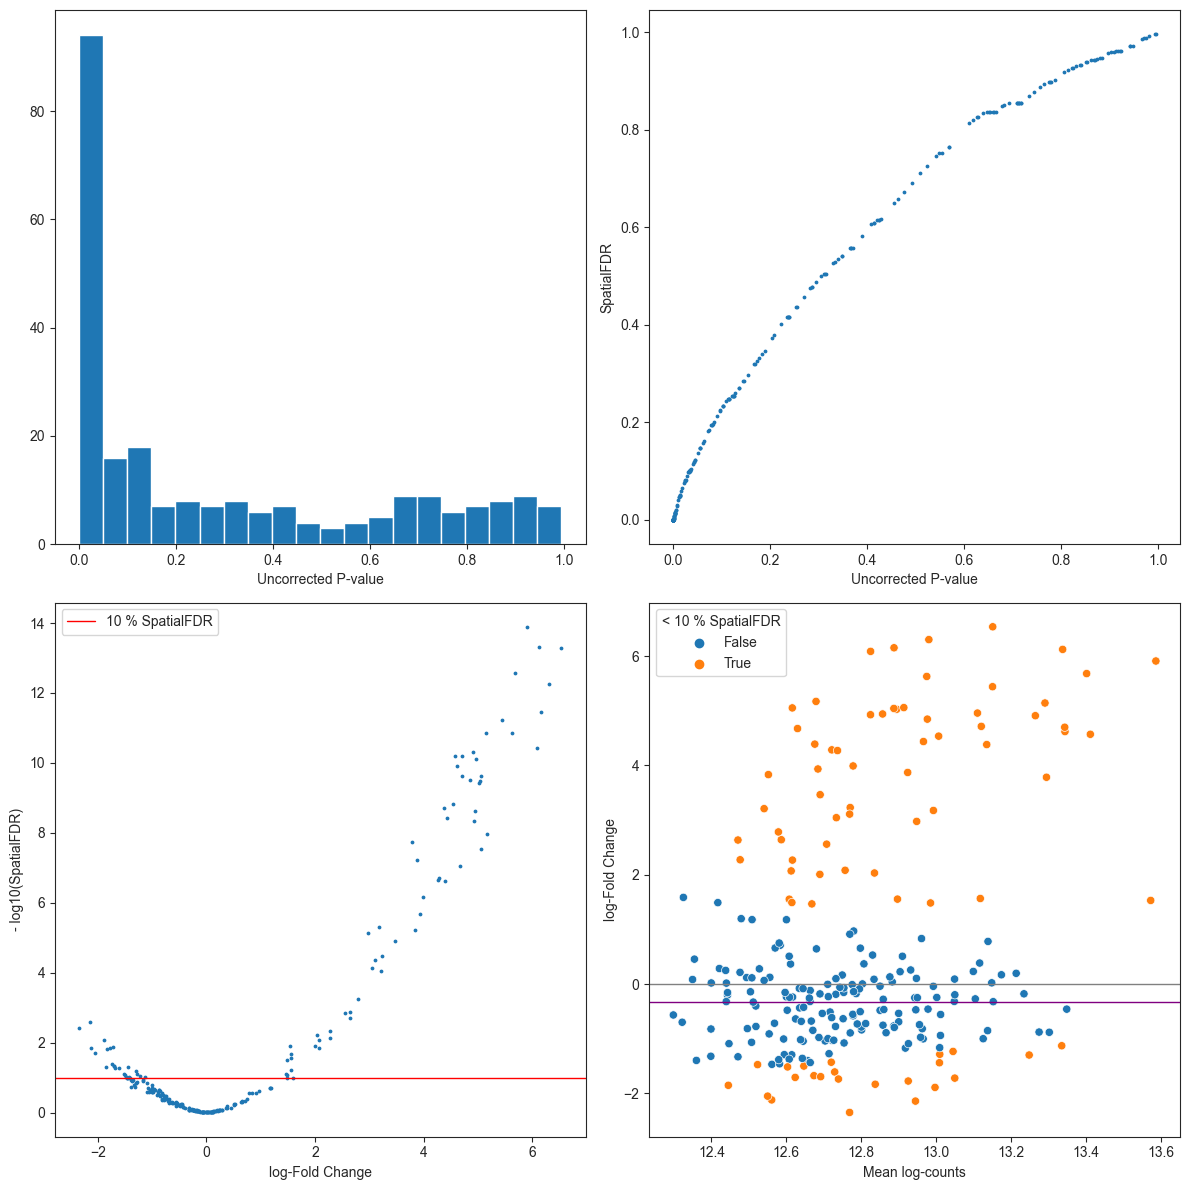

In [19]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

## Plotting of log fold change in cell compartments

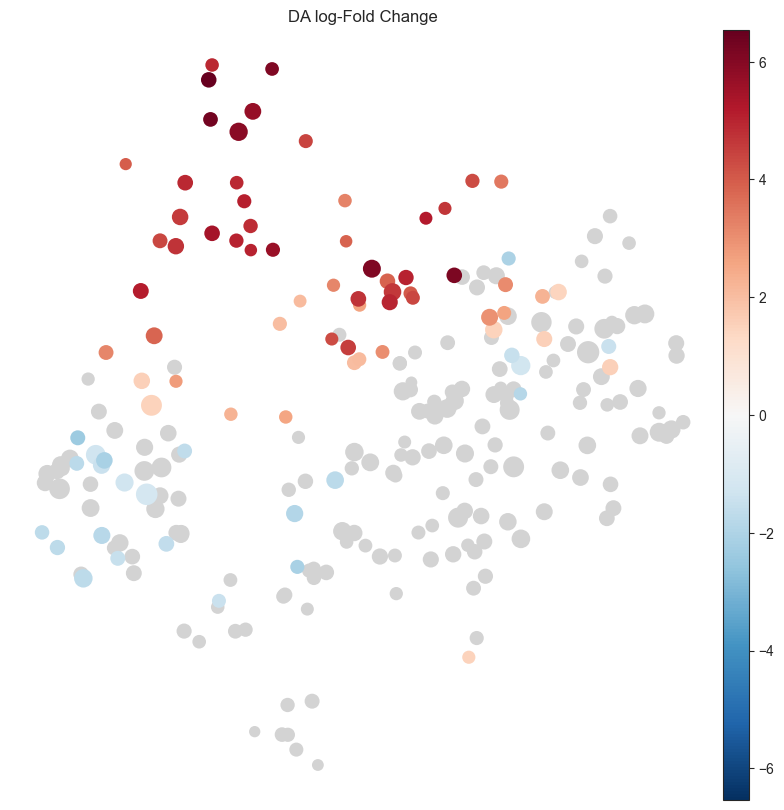

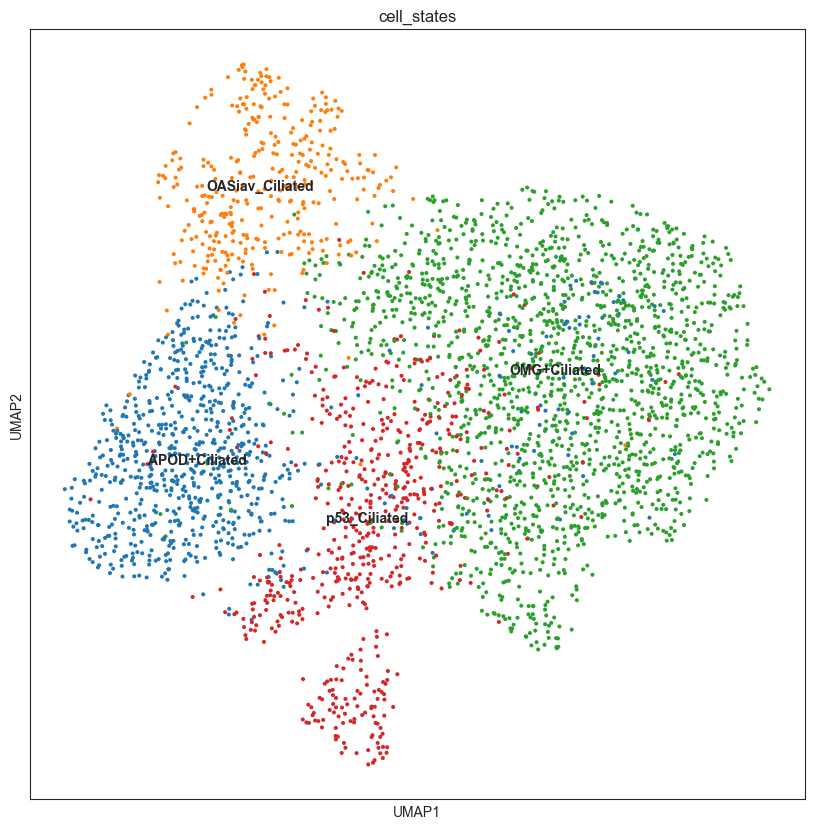

In [20]:
milo.build_nhood_graph(mdata)
with matplotlib.rc_context({"figure.figsize": [10, 10]}):
    pt.pl.milo.nhood_graph(mdata, alpha=0.1, min_size=5, plot_edges=False)
    sc.pl.umap(mdata["rna"], color="cell_states", legend_loc="on data")

In [21]:
milo.annotate_nhoods(mdata, anno_col="cell_states")
# Define as mixed if fraction of cells in nhood with same label is lower than 0.75

#mdata["milo"].var.loc[
#    mdata["milo"].var["nhood_annotation_frac"] < 0.75, "nhood_annotation"
#] = "Mixed"

['OASiav_Ciliated', 'OMG+Ciliated', 'APOD+Ciliated', 'p53_Ciliated']


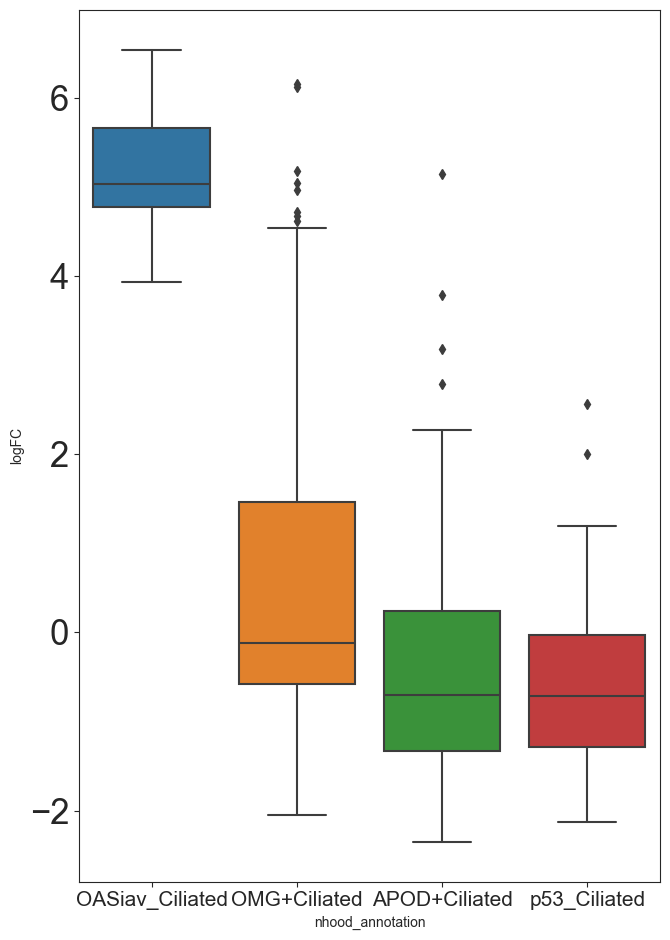

In [22]:
ranks = mdata["milo"].var.groupby("nhood_annotation")["logFC"].mean().fillna(0).sort_values()[::-1].index.tolist()
print(ranks)
plt.figure(figsize=(6.8, 9.5), tight_layout=True)
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC", order=ranks)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=25)

In [23]:
def significance_ratios(mdata_object):
    d = {"cell_compartments": [], "significance_ratio": []}
    for i in mdata_object["milo"].var["nhood_annotation"].unique():
        significant = 0
        insignificant = 0
        d["cell_compartments"].append(i)
        for j in mdata_object["milo"].var[mdata_object["milo"].var["nhood_annotation"].isin([i])]["Sig"]:
            if j == True:
                significant += 1
            else:
                insignificant += 1
        d["significance_ratio"].append(significant/(significant+insignificant))
    df = pd.DataFrame.from_dict(data=d)
    return df

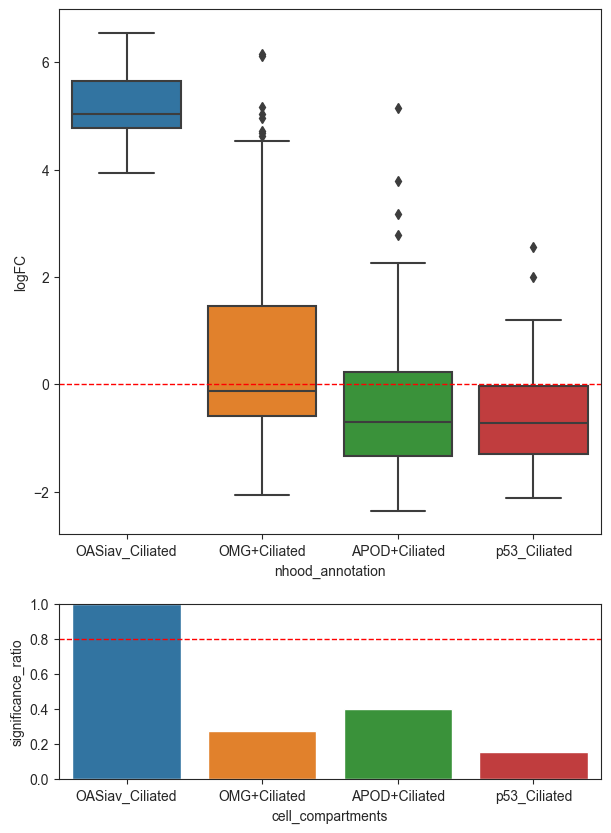

In [27]:
significance = significance_ratios(mdata)
order = mdata["milo"].var.groupby("nhood_annotation")["logFC"].mean().fillna(0).sort_values()[::-1].index.tolist()
fig, axs = plt.subplots(2, figsize=(7,10), gridspec_kw={'height_ratios': [3, 1]})
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC", order=order, ax=axs[0])
axs[0].axhline(y=0, color='r', linewidth=1, linestyle='--')
sns.barplot(data=significance, x="cell_compartments", y="significance_ratio", order=order, ax=axs[1])
plt.ylim(0, 1)
axs[1].axhline(y=0.8, color='r', linewidth=1, linestyle='--')